In [2]:
%load_ext autoreload
%autoreload 2
import sys
import torch
from torch import nn
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Union
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models.fc import FC
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

from erank.data.datasetgenerator import DatasetGenerator
from erank.utils import load_directions_matrix_from_task_sweep
from ml_utilities.data_utils import calculate_dataset_mean_std, show_images
from ml_utilities.utils import convert_dict_to_python_types
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = '/home/max/phd/data'

## Compute normalizer for MNIST

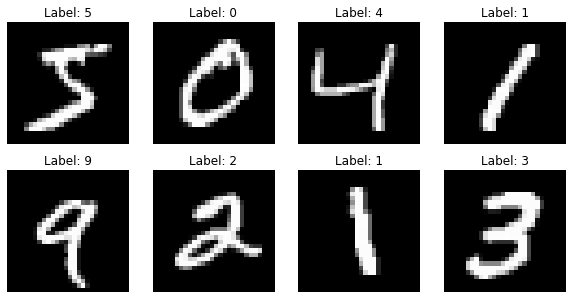

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train_unnormalized = torchvision.datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
show_images(mnist_train_unnormalized, 10, 4, cmap='gray', shuffle=False)

In [5]:
mean, std = calculate_dataset_mean_std(mnist_train_unnormalized)
normalizer = dict(mean=mean, std=std)
normalizer = convert_dict_to_python_types(normalizer, single_vals_as_list=True)
normalizer

100%|██████████| 235/235 [00:04<00:00, 47.48it/s]


{'mean': [0.1306605190038681], 'std': [0.3015042245388031]}

In [6]:
mean, std

(tensor([0.1307]), tensor([0.3015]))

## Rotation transformation on MNIST

use interpolation mode Bilinear -> images look closer to original images at arbitrary angles

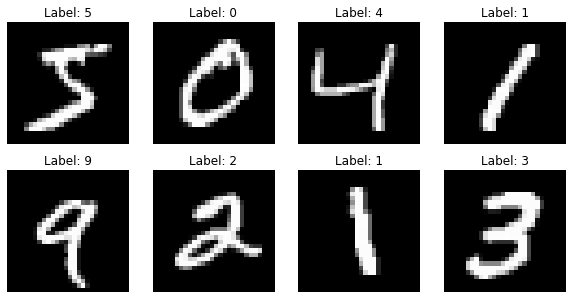

In [7]:
rotation=0
interpolation = transforms.InterpolationMode.NEAREST

transform = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation((rotation,rotation), interpolation=interpolation)])
mnist_train_unnormalized = torchvision.datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
show_images(mnist_train_unnormalized, 10, 4, cmap='gray', shuffle=False)

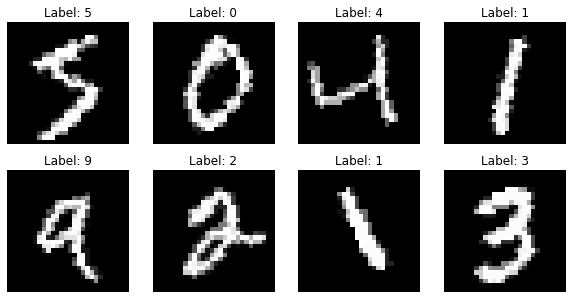

In [8]:
rotation=17
interpolation = transforms.InterpolationMode.NEAREST

transform = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation((rotation,rotation), interpolation=interpolation)])
mnist_train_unnormalized = torchvision.datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
show_images(mnist_train_unnormalized, 10, 4, cmap='gray', shuffle=False)

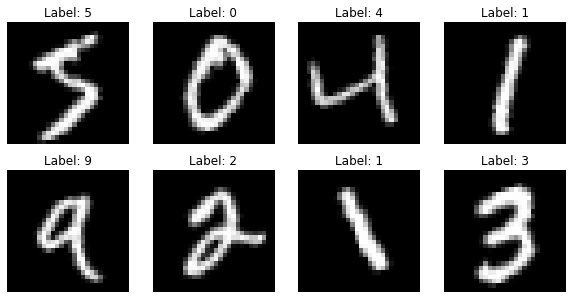

In [9]:
rotation=17
interpolation = transforms.InterpolationMode.BILINEAR

transform = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation((rotation,rotation), interpolation=interpolation)])
mnist_train_unnormalized = torchvision.datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
show_images(mnist_train_unnormalized, 10, 4, cmap='gray', shuffle=False)

## Rotated Vision Dataset

In [10]:
data_cfg = f"""
data:
  dataset: rotatedvision 
  dataset_kwargs:
    data_root_path: {data_dir}
    dataset: mnist
    rotation_angle: 180
  dataset_split:
    train_val_split: 0.8
"""
data_cfg = OmegaConf.create(data_cfg)
data_cfg = data_cfg.data
print(OmegaConf.to_yaml(data_cfg))

dataset: rotatedvision
dataset_kwargs:
  data_root_path: /home/max/phd/data
  dataset: mnist
  rotation_angle: 180
dataset_split:
  train_val_split: 0.8



In [11]:
dataset_generator = DatasetGenerator(dataset=data_cfg.dataset,
                                     dataset_kwargs=data_cfg.dataset_kwargs,
                                     dataset_split=data_cfg.dataset_split)
dataset_generator.generate_dataset()
train_set, val_set = dataset_generator.train_split, dataset_generator.val_split

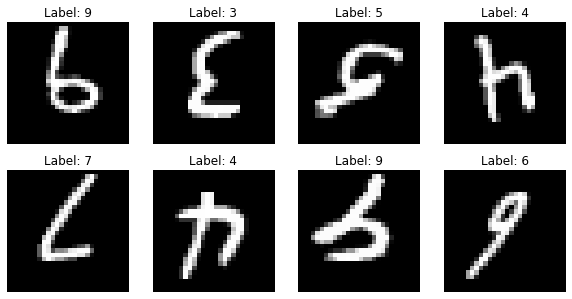

In [12]:
show_images(train_set, 10, 4, cmap='gray', shuffle=False)

In [13]:
# mean, std = calculate_dataset_mean_std(train_set)
# mean, std

In [15]:
train_set[0][0].shape

torch.Size([1, 28, 28])